In [1]:
%load_ext autoreload
%autoreload 2

from led_controllers_utils import *


In [2]:
delimiters = [',', ' ', ';', ':', '+','/']  # List of possible delimiters

while True:
    
    led_csv_file = "IlluminationData.csv"
    leds_csv = load_spectral_dict_from_csv(led_csv_file)
    save_obj(leds_csv, "./IlluminationData.pkl")
    all_leds = [color for color in leds_csv.keys() if color != "x_axis"]
    
    print(f"\nPlease select LEDs (available in {led_csv_file}) : ")
    for i, led in enumerate(all_leds, start=1):
        print(f"{i}. {led}")

    try:
        user_input = input("Enter numbers: ")

        # Replace each delimiter with a space
        for delimiter in delimiters:
            user_input = user_input.replace(delimiter, ' ')

        # Split the input by spaces and convert to integers
        choices = [int(x.strip()) for x in user_input.split() if x.strip()]
        selected_leds = [all_leds[i-1] for i in choices if 1 <= i <= len(all_leds)]

        if selected_leds:
            print(f"\nYou selected: {', '.join(selected_leds)}")
            break
        else:
            print("Invalid selection, try again.")
    except ValueError:
        print("Invalid input. Please enter numbers separated by valid delimiters.")


Please select LEDs (available in IlluminationData.csv) : 
1. Violet
2. Blue
3. Green
4. Yellow
5. Red
6. test
Enter numbers: 3 4 5

You selected: Green, Yellow, Red



--- CORRECTION PHASE ---
Power of Green LED at 5V (Current: 0.35 mW): 
Power of Yellow LED at 5V (Current: 0.87 mW): 
Power of Red LED at 5V (Current: 21.5 mW): 


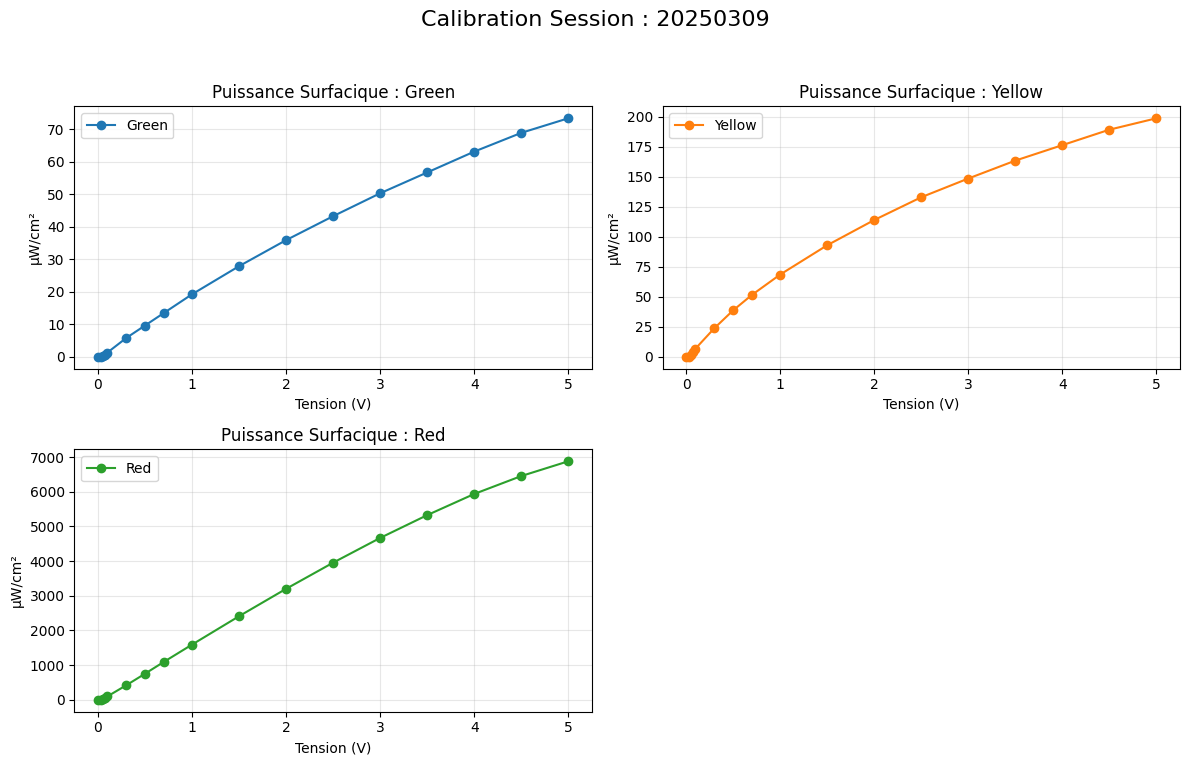

In [5]:
calibration_file = r"./calibration_5_colors_w_MEA_20230403.xlsx"

corrections = get_corrections(all_LEDs=selected_leds)
save_correction_to_txt(corrections)

calibration = charge_calibration(calibration_file, corrections, selected_LEDs=selected_leds, verbose=True)

In [10]:
file_path = './Example_PowerList.txt'
# On remplace l'extension et le nom pour le fichier de sortie
output_file_path = file_path.replace('.txt', '.csv').replace('PowerList', 'VoltageList')

# Calcul du nombre de lignes pour la barre de progression tqdm
total_lines = sum(1 for _ in open(file_path, 'r'))

with open(file_path, 'r') as file, open(output_file_path, 'w') as output_file:
    for line in tqdm(file, desc='Converting Powers to Voltage', total=total_lines):
        # Extraction des puissances de la ligne (split par espace ou tab)
        Ptot = list(map(float, line.split()))

        # Vérification de cohérence entre le fichier texte et les LEDs sélectionnées
        if len(Ptot) != len(selected_leds):
             raise ValueError(f"Erreur de dimension : {len(Ptot)} colonnes dans le texte vs {len(selected_leds)} LEDs.")

        # Calcul des tensions avec ta fonction habituelle
        # Note : voltage doit être un tableau numpy ou une liste
        voltage = get_voltages(Ptot, calibration, selected_leds)

        # Création de la ligne CSV : on joint les valeurs par des virgules
        # f"{v:f}" permet d'éviter la notation scientifique (ex: 1e-05) pour rester lisible
        csv_line = ",".join(f"{v:f}" for v in voltage)

        # Écriture de la ligne suivie d'un retour à la ligne
        output_file.write(csv_line + "\n")

print(f"Conversion terminée. Fichier disponible ici : {output_file_path}")

Converting Powers to Voltage:   0%|          | 0/11 [00:00<?, ?it/s]

Conversion terminée. Fichier disponible ici : ./Example_VoltageList.csv


In [ ]:
pr_data = load_spectral_dict_from_csv("./PhotoReceptorData.csv") 
save_obj(pr_data, "./PhotoReceptorData.pkl")

isomerisation_target = {
    "Scones":5e2,
    "Mcones":1e4,
    'Rods':2e4
}
selected_LEDs = ['Violet', 'Yellow', 'test']

corrections = get_corrections(all_LEDs=selected_leds)
calibration = charge_calibration(calibration_file, corrections, selected_LEDs=selected_leds, verbose=True)

Ptot_solution = get_mix_color(isomerisation_target, selected_LEDs = selected_LEDs, ledDATA_path = './IlluminationData.pkl')

plot_isomerisations([Ptot_solution], selected_LEDs = selected_LEDs, colors={'Violet':'c','Yellow':'orange'},ledDATA_path = './IlluminationData.pkl')
plt.show()
plt.close('all')
get_voltages(Ptot_solution, calibration, selected_LEDs)